### Test migration history reconstruction on tracerx nsclc patients with anatomical site information (so we can use our organotropism prior)

In [1]:
import sys
import os

REPO_DIR = os.path.join(os.getcwd(), "../../")
os.chdir(REPO_DIR)

from src.lib.metient import *
from src.util import data_extraction_util as dutil

import matplotlib
import torch
import pandas as pd

custom_colors = ["#9e9e9e","#c27ba0", "#be5742e1", "#6fa8dc", "#e69138", "#6aa84f"]
TRACERX_DATA_DIR = os.path.join(REPO_DIR, 'src/data/tracerx_nsclc/')
PYCLONE_CLUSTERED_TSVS_DIR = os.path.join(TRACERX_DATA_DIR, 'patient_data', 'pyclone_clustered')
CONIPHER_TREES_DIR = os.path.join(TRACERX_DATA_DIR, 'conipher_outputs', 'TreeBuilding')
MSK_MET_FN = os.path.join(REPO_DIR, 'src/data/msk_met/msk_met_freq_by_cancer_type.csv')
OUTPUT_DIR = os.path.join(TRACERX_DATA_DIR, "metient_outputs")


def find_labeling(ref_var_fn, tree, custom_colors, primary_site, patient_name, output_dir, msk_met_map, sites_map, weights):    
    ref_matrix, var_matrix, unique_sites, idx_to_full_cluster_label = get_ref_var_matrices(ref_var_fn)

    idx_to_cluster_label = dict()
    for ix in idx_to_full_cluster_label:
        og_label_muts = idx_to_full_cluster_label[ix].split(';') # e.g. CUL3:2:225371655:T;TRPM6:9:77431650:C
        if len(og_label_muts) > 3:
            og_label_muts = og_label_muts[:3]
        gene_names = []
        for mut_label in og_label_muts:
            gene_names.append(mut_label.split(":")[0])
        idx_to_cluster_label[ix] = ("_").join(gene_names)
    print(idx_to_cluster_label)
    print(tree.shape)
    G = get_genetic_distance_matrix_from_adj_matrix(tree,idx_to_full_cluster_label, ";")
    O = get_organotropism_matrix_from_msk_met(unique_sites, "Non-Small Cell Lung Cancer", MSK_MET_FN, msk_met_map)
    print("O", O)
    unique_sites = [sites_map[site] for site in unique_sites]
    print(f"Anatomical sites: {unique_sites}")   

    print_config = PrintConfig(visualize=False, verbose=False, viz_intermeds=False, k_best_trees=5)
    get_migration_history(tree, ref_matrix, var_matrix, unique_sites, "Lung", idx_to_cluster_label,
                          weights, print_config, output_dir, patient_name, G=G, 
                          weight_init_primary=True, custom_colors=custom_colors, 
                          batch_size=2000, max_iter=100, lr_sched='step')

    
def run_conipher_patient(patient, weights, tsv_dir, tree_dir, msk_met_map, sites_map, output_dir):
    space = "x"*44
    tsv_fn = os.path.join(tsv_dir, f"{patient}_clustered_SNVs.tsv")
    print(f"{space} PATIENT {patient} {space}")
    df = pd.read_csv(tsv_fn, delimiter="\t")
    primary_sites = list(df[df['sample_type']=='primary']['anatomical_site_label'].unique())
    if (len(primary_sites) > 1):
        print("*Multiple primary samples, running metient once for each possible primary*")
    for primary_site in primary_sites:
        print(f"Primary site: {primary_site}")
        run_name = f"{patient}_{primary_site}"
        tree_fn = os.path.join(tree_dir, f"{patient}_conipher_SNVsallTrees_cleaned.txt")
        trees = dutil.get_adj_matrices_from_all_conipher_trees(tree_fn)
        find_labeling(tsv_fn, trees[0], custom_colors, primary_site, run_name, output_dir, msk_met_map, sites_map, weights)


NOTE: Redirects are currently not supported in Windows or MacOs.


CUDA GPU: False


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx PATIENT CRUK0484 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Primary site: primary_SU_T1
{0: 'TMPRSS12_MILR1_SLC7A10', 1: 'EIF4E2_PKHD1L1_FAP', 2: 'RAPGEF2_UBA6_TMEM132D', 3: 'TRAPPC6B_ZEB2_ELMOD1', 4: 'PSMA7_ATP1A1_CPVL', 5: 'PDE7A_HK3_TENM2', 6: 'CHGB_DDI2_ZNF792', 7: 'PEX2_AGTPBP1_CYB5A', 8: 'PCDHGB2_CSPG4_STEAP2', 9: 'PML_XIRP1_MUC16', 10: 'SLIT1_KIAA1598_CSTF2T', 11: 'RNF44_CACNA1E_EPHB6', 12: 'PCDHGA12_LRP6_NRP1', 13: 'MYL2_KCTD7_FRMD3', 14: 'TDRD6_PAX5_SLC26A10', 15: 'PTPRA_PTPRT_MUC16', 16: 'CHRNA4_WNT6_LBP', 17: 'SECISBP2_CELF4_NTNG2', 18: 'STON1_TNC_MKL1', 19: 'HACE1_SLC35D2_CENPF', 20: 'FN1_RNU6-71P_DLGAP2', 21: 'GHSR_TMED3_ZNF254', 22: 'TOP3B_TDRD5_CHAF1B', 23: 'ITGA1_SHROOM1_MALRD1', 24: 'PABPC1_OR5R1_FAT1', 25: 'FAM83E_MYOM2_KATNBL1', 26: 'PKHD1_DHRS9_TSPAN1', 27: 'SAP30L-AS1_BCAP29_USP4', 28: 'PLEKHH1_ZNF318_OTOF', 29: 'GJA8_VPS45_FBXO32', 30: 'CD109_DISC1_LRRC43', 31: 'ZNF254_EDN3_SLX4', 32: 'NLRP11_NUTF2_AKNA'}
torch.Size([

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:32<00:00,  5.73s/it]


Saving CRUK0484_primary_SU_T1 to /Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/jupyter_notebooks/../../src/data/tracerx_nsclc/metient_outputs


<Figure size 640x480 with 0 Axes>

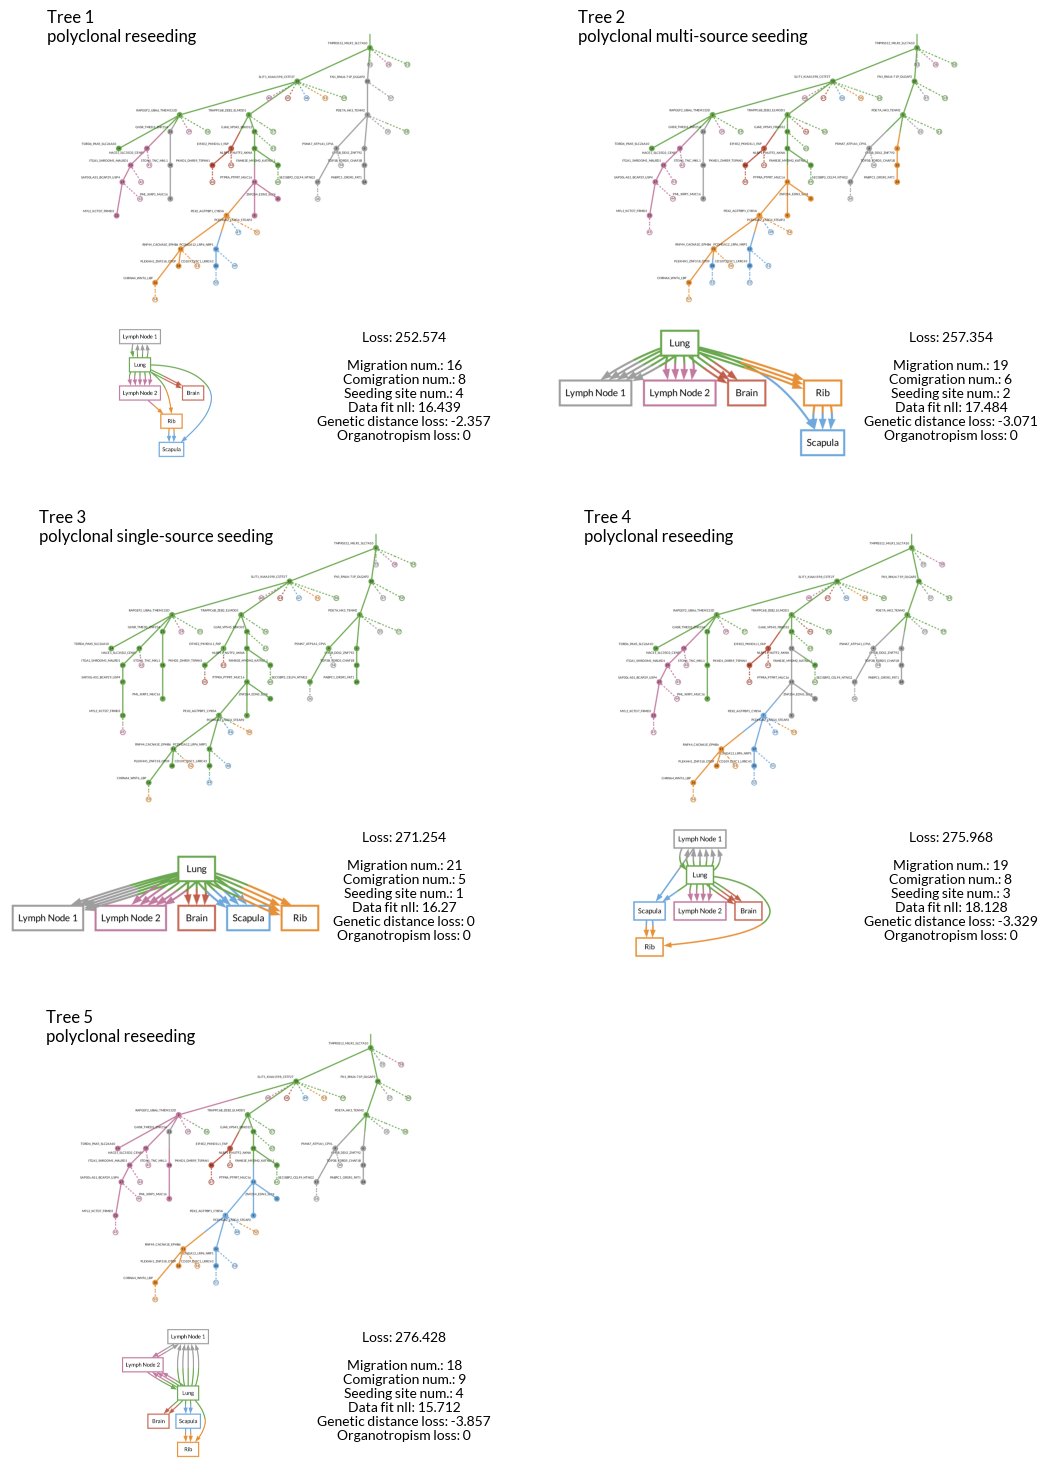

In [3]:
CRUK0484_msk_met_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Distant LN",
    "LN_SU_LN1" : "Distant LN",
    "metachronousMet_BP_T1" : "CNS/Brain",
    "metachronousMet_BP_T1.FR1" : "Bone",
    "metachronousMet_BR_T1" : "Bone"
}

# For visualization on migraiton graph
sites_map = {
    "primary_SU_T1" : "Lung",
    "LN_SU_FLN1" : "Lymph Node 1",
    "LN_SU_LN1" : "Lymph Node 2",
    "metachronousMet_BP_T1" : "Brain",
    "metachronousMet_BP_T1.FR1" : "Scapula",
    "metachronousMet_BR_T1" : "Rib"
}

weights = Weights(data_fit=0.2, mig=10.0, comig=7.0, seed_site=5.0, reg=3.0, gen_dist=2.0, organotrop=10.0)
run_conipher_patient("CRUK0484", weights, PYCLONE_CLUSTERED_TSVS_DIR, CONIPHER_TREES_DIR, CRUK0484_msk_met_map, sites_map, OUTPUT_DIR)